In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay


In [5]:
from google.colab import files
uploaded = files.upload()


Saving data.csv to data (1).csv


In [6]:
# Load dataset
data = pd.read_csv("data.csv")

# Show first 5 rows
print(data.head())

# Check missing values & info
print(data.info())
print(data.isnull().sum())


         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

In [8]:
# Cell 3: detect target (prefer 'diagnosis') and encode to 0/1
if 'diagnosis' in df.columns:
    target_col = 'diagnosis'
else:
    candidates = [c for c in df.columns if df[c].nunique() == 2]
    target_col = candidates[0] if candidates else None
    if target_col is None:
        raise ValueError("No binary target found. Tell me the target column name.")

# Encode common M/B -> 1/0, otherwise factorize
if df[target_col].dtype == 'object' or not pd.api.types.is_numeric_dtype(df[target_col]):
    if set(df[target_col].unique()) <= {'M','B'}:
        df[target_col] = df[target_col].map({'M':1, 'B':0})
    else:
        df[target_col], _ = pd.factorize(df[target_col])

print("Using target:", target_col)
print(df[target_col].value_counts())


Using target: diagnosis
diagnosis
0    357
1    212
Name: count, dtype: int64


In [9]:
# Cell 4: create X, y and drop any non-numeric features
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

non_numeric = X.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric:
    print("Dropping non-numeric columns:", non_numeric)
    X = X.drop(columns=non_numeric)

print("Final X shape:", X.shape, "y distribution:\n", y.value_counts())


Final X shape: (569, 32) y distribution:
 diagnosis
0    357
1    212
Name: count, dtype: int64


In [10]:
# Cell 5: stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (455, 32) Test: (114, 32)


In [11]:
# Cell 6: scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [14]:
# Debug X_train and y_train before fitting
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)

# Check for NaN or infinite values
import numpy as np
print("Any NaN?", np.isnan(X_train).any())
print("Any Inf?", np.isinf(X_train).any())

print("y_train unique values:", np.unique(y_train))


X_train type: <class 'numpy.ndarray'>
X_train shape: (455, 32)
Any NaN? True
Any Inf? False
y_train unique values: [0 1]


In [16]:
# Replace NaN or Inf with 0
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)


In [17]:
# Step 7 (fixed)
model = LogisticRegression(max_iter=2000, solver='lbfgs')
model.fit(X_train, y_train)


LogisticRegression(max_iter=2000)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



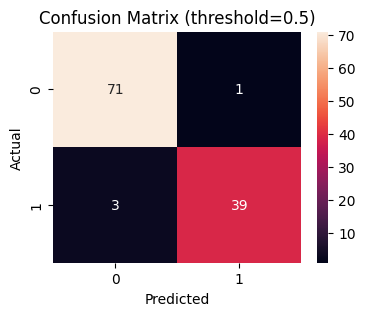

In [18]:
# Cell 8: predict and show confusion matrix + report
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (threshold=0.5)")
plt.show()


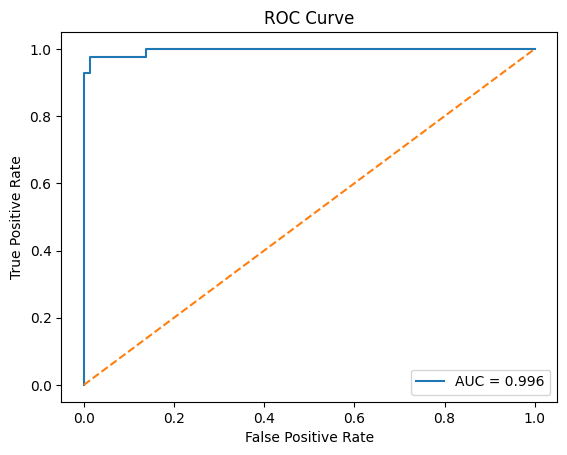

ROC AUC: 0.996031746031746


In [19]:
# Cell 9: ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thr = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC:", roc_auc)


In [21]:
from sklearn.metrics import precision_score, recall_score


In [22]:
# Cell 10: threshold tuning
from sklearn.metrics import precision_score, recall_score

for th in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_t = (y_proba >= th).astype(int)
    p = precision_score(y_test, y_t)
    r = recall_score(y_test, y_t)
    print(f"Threshold {th:.1f}  ->  Precision: {p:.3f}, Recall: {r:.3f}")
    print(" Confusion matrix:\n", confusion_matrix(y_test, y_t))
    print("---")


Threshold 0.3  ->  Precision: 0.976, Recall: 0.976
 Confusion matrix:
 [[71  1]
 [ 1 41]]
---
Threshold 0.4  ->  Precision: 0.976, Recall: 0.952
 Confusion matrix:
 [[71  1]
 [ 2 40]]
---
Threshold 0.5  ->  Precision: 0.975, Recall: 0.929
 Confusion matrix:
 [[71  1]
 [ 3 39]]
---
Threshold 0.6  ->  Precision: 1.000, Recall: 0.905
 Confusion matrix:
 [[72  0]
 [ 4 38]]
---
Threshold 0.7  ->  Precision: 1.000, Recall: 0.905
 Confusion matrix:
 [[72  0]
 [ 4 38]]
---


In [23]:
# Cell 11: show how sigmoid maps raw score to probability
z = model.decision_function(X_test)   # raw linear scores w·x + b
sigmoid = 1 / (1 + np.exp(-z))
for i in range(6):
    print(f"z={z[i]:.3f}  sigmoid={sigmoid[i]:.4f}  predict_proba={y_proba[i]:.4f}")


z=-7.928  sigmoid=0.0004  predict_proba=0.0004
z=18.337  sigmoid=1.0000  predict_proba=1.0000
z=-3.127  sigmoid=0.0420  predict_proba=0.0420
z=0.282  sigmoid=0.5700  predict_proba=0.5700
z=0.045  sigmoid=0.5111  predict_proba=0.5111
z=-7.396  sigmoid=0.0006  predict_proba=0.0006
